# Introduction - Predicting House Sale Prices

In this project, we'll be building a linear regression model that would help us predict housing prices based on a dataset of houses from Ames, Iowa, USA from 2006 - 2010. You can find the dataset and some additional information on the dataset below:

> Link to dataset:
https://dsserver-prod-resources-1.s3.amazonaws.com/235/AmesHousing.txt

> Reason data was collected: https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627

> Information on the different columns in the dataset: https://s3.amazonaws.com/dq-content/307/data_description.txt

Let's read in our dataset and get started!

In [127]:
# import our needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

# read in our dataset into a dataframe
housing_data = pd.read_table("AmesHousing.tsv")

# Workflow

We'll follow the following workflow for this project:
- Transform our features so that we can work them into our model
- Select our features for a model
- Create our training and test sets and figure out which of our features give us the best model (having the lowest root mean squared error when comparing our predicted prices to the actual prices in the test set).

Let's start by creating shells of these functions for each of these steps to help speed up our work. As we go along, we'll flesh them out more.

In [128]:
# create our transform features function
def transform_features(dataframe, missing_values_pct_cutoff=0.25):
    cleaned_dataframe = dataframe.copy()
    
    ## Remove the features that leak information on the sale
    cols_to_remove = ["Sale Condition","Sale Type","Mo Sold"]
    cleaned_dataframe.drop(cols_to_remove, axis=1, inplace=True)
    
    ## Remove features with more than 25% of their values missing
    total_records = cleaned_dataframe.shape[0]
    num_of_nulls_series = cleaned_dataframe.isnull().sum()
    columns_too_many_nulls = num_of_nulls_series[(num_of_nulls_series / total_records) > missing_values_pct_cutoff].index
    cleaned_dataframe.drop(columns_too_many_nulls, axis=1, inplace=True)
    
    # Create our feature for year until remodeled
    cleaned_dataframe["year_until_remodeled"] = cleaned_dataframe["Year Remod/Add"] - cleaned_dataframe["Year Built"]
    
    # Create our feature for age of house from last remodeling
    cleaned_dataframe["age_of_house_since_remodeling"] = cleaned_dataframe["Yr Sold"] - cleaned_dataframe["Year Remod/Add"]
    
    # drop those columns we used to make our new features
    cleaned_dataframe.drop(["Yr Sold","Year Built","Year Remod/Add"],inplace=True, axis=1)
    
    # drop the redundant columns and unique identifier columns that are not useful for helping us determine the price of a house
    cleaned_dataframe.drop(["MS SubClass","Garage Yr Blt","Order","PID"],inplace=True,axis=1)
    
    # convert our object columns to category values
    text_cols = cleaned_dataframe.select_dtypes(include='object')
    for col in text_cols:
        cleaned_dataframe[col] = cleaned_dataframe[col].astype('category')
    
    # bring in the dummy codes
    for col in text_cols:
        col_dummies = pd.get_dummies(cleaned_dataframe[col])
        cleaned_dataframe = pd.concat([cleaned_dataframe, col_dummies], axis=1)
        del cleaned_dataframe[col]
    
    # logic for filling out the numeric columns that have missing data with the column's mean
    null_series = cleaned_dataframe.isnull().sum() / dataframe.shape[0]
    numeric_columns_with_nulls = cleaned_dataframe[null_series[null_series > 0].index].select_dtypes(include=['float','integer']).columns
    mean_values = cleaned_dataframe[numeric_columns_with_nulls].mean()
    cleaned_dataframe[numeric_columns_with_nulls] = cleaned_dataframe[numeric_columns_with_nulls].fillna(mean_values)
    
    # logic for removing some columns that are heavily correlated with each other
    cleaned_dataframe.drop(["TotRms AbvGrd","Garage Cars","Total Bsmt SF"],axis=1,inplace=True)
    
    return cleaned_dataframe

In [129]:
# test our function above works
transformed_features = transform_features(housing_data)

In [130]:
# create our select_features function
def select_features(dataframe, corr_threshold=0.3, unique_value_threshold=5, percentage_of_values_threshold=0.95):
    cleaned_dataframe = dataframe
    
    # choose the nuermical columns that meet the correlation threshold
    ## select only the numerical columns
    cleaned_dataframe_num = cleaned_dataframe.select_dtypes(include=['float','int'])
    ## Create a dataframe of numerical columns and how they are correlated with each other
    cleaned_dataframe_num_corr = cleaned_dataframe_num.corr()
    cleaned_dataframe_num_corr = abs(cleaned_dataframe_num_corr)
    ##  create a series of sorted correlations of the columns with SalePrice
    sorted_corrs = cleaned_dataframe_num_corr["SalePrice"].sort_values()
    # drop those that do not fall within our threshold
    low_corr_features = sorted_corrs[sorted_corrs<corr_threshold].index
    cleaned_dataframe.drop(low_corr_features,axis=1,inplace=True)
    
    # logic to check if a categorical feature has more than a certain number of features. If so, drop the column
    string_cols_data = cleaned_dataframe.select_dtypes(include='object')
    unique_values = string_cols_data.nunique()
    cols_to_drop = unique_values[unique_values>unique_value_threshold].index
    cleaned_dataframe.drop(cols_to_drop,axis=1,inplace=True)
    
    # logic to check if a categorical feature is over a certain threshold of one value. If so, drop the column
    string_cols_data = cleaned_dataframe.select_dtypes(include='object')
    string_cols = string_cols_data.columns
    for col in string_cols:
        max_percentage_of_values = string_cols_data[col].value_counts(dropna=False,normalize=True).max()
        if max_percentage_of_values >= percentage_of_values_threshold:
            cleaned_dataframe.drop(col,axis=1,inplace=True)

    return cleaned_dataframe

In [131]:
# test out our select_features function
select_features_test = select_features(transformed_features)
select_features_test.head()

,Lot Frontage,Overall Qual,Mas Vnr Area,BsmtFin SF 1,1st Flr SF,Gr Liv Area,Full Bath,Fireplaces,Garage Area,Wood Deck SF,...,Po,TA,Ex,Fa,Gd,Po,TA,N,P,Y
0,141.0,6,112.0,639.0,1656,1656,1,2,528.0,210,...,0,1,0,0,0,0,1,0,1,0
1,80.0,5,0.0,468.0,896,896,1,0,730.0,140,...,0,1,0,0,0,0,1,0,0,1
2,81.0,6,108.0,923.0,1329,1329,1,0,312.0,393,...,0,1,0,0,0,0,1,0,0,1
3,93.0,7,0.0,1065.0,2110,2110,2,2,522.0,0,...,0,1,0,0,0,0,1,0,0,1
4,74.0,5,0.0,791.0,928,1629,2,1,482.0,212,...,0,1,0,0,0,0,1,0,0,1


In [132]:
# create a function for training and testing our model
def train_and_test(dataframe, k):
    
    # create a copy of our dataframe to not modify the original
    dataframe_copy = dataframe.copy()
    
    #use our other functions to transform the features and select them
    transformed_dataframe = transform_features(dataframe_copy)
    cleaned_dataframe = select_features(transformed_dataframe)

    # select our features and target
    numeric_dataframe = cleaned_dataframe.select_dtypes(include=['integer','float'])
    features = list(numeric_dataframe.columns)
    features.remove("SalePrice")
    target = ["SalePrice"]
    
    # if k = 0, perform holdout validation
    if k == 0:
        # build our linear regression model
        lr = LinearRegression()
        train = cleaned_dataframe[:1460]
        test = cleaned_dataframe[1460:]
        lr.fit(train[features],train[target])
        test_predictions = lr.predict(test[features])
        mse = mean_squared_error(test_predictions, test[target])
        rmse = np.sqrt(mse)
        
    # if k = 1, perform a simple cross validation
    elif k == 1:
        # create a list for the rmse
        rmse_list = []
        
        # scramble the dataset
        dataframe.iloc[np.random.permutation(dataframe.shape[0])]
        fold_one = cleaned_dataframe[:1460]
        fold_two = cleaned_dataframe[1460:]
        
        # test one
        lr1 = LinearRegression()
        lr1.fit(fold_one[features],fold_one[target])
        test_predictions = lr1.predict(fold_two[features])
        mse_1 = mean_squared_error(test_predictions, fold_two[target])
        rmse_1 = np.sqrt(mse_1)
        rmse_list.append(rmse_1)
        
        # test two
        lr2 = LinearRegression()
        lr2.fit(fold_two[features],fold_two[target])
        test_predictions = lr2.predict(fold_one[features])
        mse_2 = mean_squared_error(test_predictions, fold_one[target])
        rmse_2 = np.sqrt(mse_2)
        rmse_list.append(rmse_2)
        
        # compute the average rmse
        rmse = np.mean(rmse_list)
        
    # if k > 1, perform a k fold validation
    if k > 1:
        # create the kfolds
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        # build our linear regression model
        lr = LinearRegression()
        mses = cross_val_score(lr, cleaned_dataframe[features],dataframe["SalePrice"],scoring='neg_mean_squared_error',cv=kf)
        abs_mses = abs(mses)
        rmses = abs_mses ** (1/2)
        rmse = np.mean(rmses)
    
    return rmse

In [133]:
test_2 = train_and_test(housing_data,k=5)
test_2

28620.12693067753

# Updating our transform_features function to clean and transform our features

Now that we've created shells of our functions, let's fill them out more starting with the transform_features() function.

For the transform_features() function, we'll remove features with many missing values. We'll set our cutoff to be 25%, so any column in our dataset with more than 25% missing values will be dropped.

We also want to avoid features that "leak" information about the house sale such ase the year the sale happened. "Data leakage" in the context of machine learning is defined below with the source where I got this definition below as well:

> **What is Data Leakage in Machine Learning?**

>Data leakage can cause you to create overly optimistic if not completely invalid predictive models. 

> Data leakage is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.

> Source: https://machinelearningmastery.com/data-leakage-machine-learning/

In sum, we want our transform_features() column to do the following:
- remove the features we don't want to use in the model, such as those with a lot of missing values or that leak information on our target.
- transform our features into the proper format such as filling in missing values and/or making a text datatype numerical if numbers are involved among other formatting changes
- create new features by combining other features

Let's get to filling out our function now!

# Avoiding Data Leakage

To avoid data leakage in our model here, we want to avoid including columns that pertain to details around the sale. From looking at the descriptions of the different columns, the following columns pertain to the sale specifically:

- SalePrice - The price the house sold for (NOTE: we're ultimately trying to predict this, so we wouldn't include this anyway in features anyway)
- Sale Condition - The condition of the sale - this denotes how the sale happened. It doesn't give us details on the particular house before the sale was made
- Sale Type - Type of sale - also gives details on the particular sale rather than details on the house
- Mo Sold - The month the house was sold in


For Yr Sold (The year the house was sold in), we'll use this  column later to help us with getting the age of the house at the time of the sale.

We'll add the following logic below to our transform_features() function.

In [134]:
# logic for removing the columns that cause data leakage
practice_dataset = housing_data.copy()
cols_to_remove = ["SalePrice","Sale Condition","Sale Type","Mo Sold"]
practice_dataset = practice_dataset.drop(cols_to_remove, axis=1)
practice_dataset.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

With the columns that would result in data leakage removed, let's now look at removing those columns with too many missing values.

In [135]:
# observe the missing values of our different features
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [136]:
# develop the logic to remove the features with more than the cutoff % of its values missing
missing_values_cutoff = 0.25
total_records = housing_data.shape[0]
num_of_nulls_series = housing_data.isnull().sum()
columns_too_many_nulls = num_of_nulls_series[(num_of_nulls_series / total_records) > missing_values_cutoff].index

# drop the columns that have too many nulls
# practice_dataset = housing_data.copy()
practice_dataset.drop(columns_too_many_nulls, axis=1, inplace=True)
practice_dataset.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars',

# Feature Engineering - Creating features from current set of features and Dropping redundant/unneccesarry columns

One feature that I think would be helpful is how long it'd been since the house had been built until it was remodeled. We can create this feature by taking the difference between Year Built and Year Remod/Add. I'd also like to know the overall age of the house at the time of the sale. We can create that feature by taking the difference between Year Remod/Add (it's the same as Year Built if it wasn't remodeled) and Yr Sold. After creating both of these features, we will drop the Year Built, Year Remod/Add, and Yr Sold columns.

We also want to make sure that we don't include columns that have give us the same information, or else it'll add too much weight to that one overall feature being shown more than once. 

For instance, we have the MS SubClass which gives us information on how many stories the house is and how old the house is. However, we also have House Style which gives us how many stories and Year Built which tells us what year the house was built in. As a result, we can drop MS SubClass and similar features that are already better told with other features. We can also drop Garage Yr Blt as that would most likely resemble Year Built.

Also, the Order and PID columns are just unique identifiers in the table. They won't help us in predicting the price as each house will just get a unique identifier if added to the list, and it could just be based on what order the data was entered into the table. As a result, we'll drop these columns as well.

In [137]:
# Create our feature for year until remodeled
practice_dataset["year_until_remodeled"] = practice_dataset["Year Remod/Add"] - practice_dataset["Year Built"]

# Create our feature for age of house from last remodeling
practice_dataset["age_of_house_since_remodeling"] = practice_dataset["Yr Sold"] - practice_dataset["Year Remod/Add"]

# drop those columns we used to make our new features
practice_dataset.drop(["Yr Sold","Year Built","Year Remod/Add"],inplace=True, axis=1)

In [138]:
# drop the redundant columns and the unique identifier columns
practice_dataset.drop(["MS SubClass","Garage Yr Blt","Order","PID"],inplace=True,axis=1)

# Feature Engineering - Making Categorical Features usable

Categorical features are columns that have set list of values to choose from. For instance, the feature Utilities  can have a value of AllPub (All public Utilities), NoSewr (just Electricity, Water, and Gas), NoSeWa (Just Electricity and Gas), or ELO (Electricity Only).

From looking through the definitions of all of the features via the link in the first cell, I found that the following columns are categorical:

- Ms Zoning
- Street
- Alley
- Lot Shape
- Land Contour
- Utilities
- Lot Config
- Land Slope
- Neighborhood
- Condition1
- Condition2
- BldgType
- House Style
- Roof Style
- Roof Matl
- Exterior 1st
- Exterior 2nd
- Mas Vnr Type
- Exter Qual
- Exter Cond
- Overall Qual (NOTE - Numerical but ordinal values. The distance between the numbers doesn't give us an idea of how much higher quality the house is)
- Overall Cond (NOTE - see above for Overall Qual)
- Foundation
- Bsmt Qual
- Bsmt Cond
- BsmtFin Type 1
- BsmtFin Type 2
- Heating
- Heating QC
- Central Air
- Electrical
- Kitchen Qual
- Functional
- Fireplace Qu
- Garage Type
- Garage Finish
- Paved Drive
- Pool QC
- Fence
- Misc Feature

Let's change each of these columns into a categorical code, and then we'll convert the codes into binary dummy codes so it's a 1 or 0 flag to say whether it falls in that category or not.

In [139]:
# convert our object columns above to category values
text_cols = practice_dataset.select_dtypes(include='object')
for col in text_cols:
    practice_dataset[col] = practice_dataset[col].astype('category')

# bring in the dummy codes
for col in text_cols:
    col_dummies = pd.get_dummies(practice_dataset[col])
    practice_dataset = pd.concat([practice_dataset, col_dummies], axis=1)
    del practice_dataset[col]

# Feature Engineering - Replacing Missing Values

With our logic for removing those columns that have more than 25% of their values missing, let's fill in the values for our other columns that are missing not as many values.

In [140]:
# For those columns that have missing values, let's see 
null_series = practice_dataset.isnull().sum() / housing_data.shape[0]
null_series[null_series > 0]

Lot Frontage      0.167235
Mas Vnr Area      0.007850
BsmtFin SF 1      0.000341
BsmtFin SF 2      0.000341
Bsmt Unf SF       0.000341
Total Bsmt SF     0.000341
Bsmt Full Bath    0.000683
Bsmt Half Bath    0.000683
Garage Cars       0.000341
Garage Area       0.000341
dtype: float64

It looks like most of these columns with missing values have only around 5% of its values missing or much less. The only outlier is Lot Frontage having around 17% of its values missing.

Let's first build out the logic to fill in the float columns with the mean of their columns.

In [141]:
# logic for filling out the numeric columns that have missing data with the column's mean
null_series = practice_dataset.isnull().sum() / housing_data.shape[0]
numeric_columns_with_nulls = practice_dataset[null_series[null_series > 0].index].select_dtypes(include='float').columns
mean_values = practice_dataset[numeric_columns_with_nulls].mean()
practice_dataset[numeric_columns_with_nulls] = practice_dataset[numeric_columns_with_nulls].fillna(mean_values)

# Selecting our Features - Modifying our select_features function - Dropping the features that are not that correlated with our target

Now that we've transformed our features, let's choose which features we want to look at and modify our select_features column.

We'll start by generating a correlation heatmap matrix of our numerical features in our training dataset, and we'll see which features strongly correlate with our target column of SalePrice.

In [142]:
# transform our features
cleaned_housing = transform_features(housing_data)

# select only the numerical columns
cleaned_housing_num = cleaned_housing.select_dtypes(include=['float','int'])

# Create a dataframe of numerical columns and how they are correlated with each other
cleaned_housing_num_corr = cleaned_housing_num.corr()
cleaned_housing_num_corr = abs(cleaned_housing_num_corr)

# create a series of sorted correlations of the columns with SalePrice
sorted_corrs = cleaned_housing_num_corr["SalePrice"].sort_values()

# drop those that do not fall within our threshold
corr_threshold = 0.3
low_corr_features = sorted_corrs[sorted_corrs<0.3].index
cleaned_housing.drop(low_corr_features,axis=1,inplace=True)

I've added the above logic to our select features column. Now, let's check to see those numerical features that are highly correlated with each other and drop one of the columns since this would indicate that the columns provide pretty much the same amount of insight into what the target column will be.

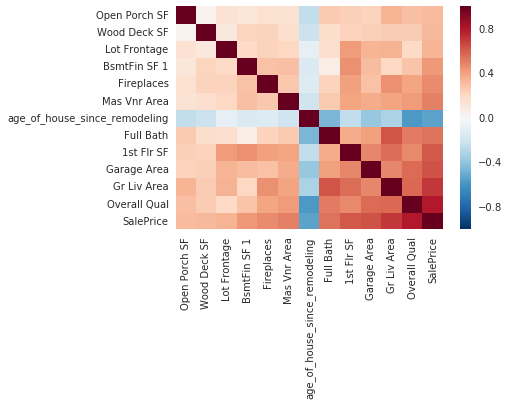

In [143]:
# create a heatmap of our correlations with SalePrice
import seaborn as sns
import matplotlib.pyplot as plt
strong_corrs = sorted_corrs[sorted_corrs>=0.3]
corrmat = cleaned_housing[strong_corrs.index]

# magic for displaying matplotlib inline
%matplotlib inline

# display the heatmap
sns.heatmap(corrmat.corr())

## Correlation Heatmap Analysis - Dropping more features that are highly correlated with each other

From our heatmap, it looks like the following fields are highly correlated with each other:

- Gr Liv Area and TotRms AbvGrd - both give an idea of the  size of the above ground living area
- Garage Area and Garage Cars - both give an idea on the size of the garage
- Total Bsmt SF and 1st Fir SF - one gives the basement area and the other the 1st floor area, but it makes sense that the two would most likely equal each other since the first floor usually covers the whole foundation of the house, and the basement underneath probably doesn't surpass that foundation as well.

Because of the correlations and reasons above, we'll remove the following columns in our transform_features function:
- TotRms AbvGrd
- Garage Cars
- Total Bsmt SF

In [144]:
# logic for removing some columns that are heavily correlated with each other
practice_dataset.drop(["TotRms AbvGrd","Garage Cars","Total Bsmt SF"],axis=1,inplace=True)

# Revisiting our Categorical Features

Though we went ahead and created a bunch of categorical features, seeing all of those dummy columns is making my head spin. Here are some things we'll consider when paring down those features:

- If a categorical feature has multiple values, there'll be multiple zero columns. How about we just look at those that have five or less values? Let's see if we can make it to where we can easily modify how many unique values we want to be our cutoff.

- If a column has over 95% of the same value, it is even worth using that column as a feature? We'll also weed out these features as well.

Let's create the logic for both of these.

In [145]:
# Check if a categorical feature has more than one feature
unique_value_threshold = 5
practice_dataset_2 = housing_data.copy()
string_cols_data = practice_dataset_2.select_dtypes(include='object')
unique_values = string_cols_data.nunique()
cols_to_drop = unique_values[unique_values>unique_value_threshold].index
practice_dataset_2.drop(cols_to_drop,axis=1,inplace=True)

In [146]:
# check if a categorical feature is 95% of one value. If so, 
percentage_of_values_threshold = 0.95
practice_dataset_3 = housing_data.copy()
string_cols_data = practice_dataset_3.select_dtypes(include='object')
string_cols = string_cols_data.columns
for col in string_cols:
    max_percentage_of_values = string_cols_data[col].value_counts(dropna=False,normalize=True).max()
    if max_percentage_of_values >= percentage_of_values_threshold:
        practice_dataset_3.drop(col,axis=1,inplace=True)

# train_and_test Function Update

With our transform_features and select_features functions built out, let's now build out our train_and_test function to train and test our model.

We have provided a "k" input in our train_and_test function to check how many folds we want to test with for cross validation. When 0 is put in, we'll just do a holdout validation. If greater than 0, we get a root mean squared error based on how many k-folds we put in for cross validation.

In [147]:
# run our train_and_test function and see how the rmse comes out
rmse = train_and_test(housing_data,k=5)

In [148]:
# let's find the average housing price
housing_data["SalePrice"].mean()

180796.0600682594

# Conclusion

In this project, we built three functions to make our lives easier when it comes to training and testing a predictive model - one function that transforms and cleans up our features, one that selects our features based on some inputted criteria, and finally a function to actually train and test the model using sci-kit learn and linear regression to give us a root mean squared error on how far off we are from our target.

When looking at our Iowa housing data and using our functions to build a linear regression model to predict housing prices, we ended up with a root mean squared error of around 29000. Since the average house price is around 180,000 dollars, a window of within around 29,000 dollars is not a bad error threshold. 

If I'm selling a house in Iowa anytime in the near future, I'd probably consult a real estate agent, but I'd use my model to give me a decent ballpark price for my house.

Thanks for reading! Until next time!